# c/d/r vine copula (vinecop) quantile regression/ conditional simulation

During vine construction, user may indicate `tpl_first` to place a set of certain vertices at shallower levels.

Equivalently, the sampling orders of fitted vine will cover `tpl_first` at the end (not necessarily the same order).

Sampling order can be derived from a given constructed vine structure.

- Full Simulation, as in `1_vinecop.ipynb`
- Quantile Regression, user may specify values for `D-1` variables (at top lv) and explore the one at deepest lv.
- Conditional Simulation, user may specify values for some variables and sim the rest.


cuda (GPU) avail? True

full simulation/ quantile-regression/ conditional-simulation using the vine copula.
        modified from depth-first search (DFS) on binary tree.
        Sequentially for each beginning vertex in the tpl_sim
        (from right to left, as from shallower lv to deeper lv in the DAG),
        walk upward by calling hinv until the top vertex (whose cond set is empty) is reached.
        (Recursively) call hfunc for the other upper vertex if necessary.

        :param num_sim: number of simulations; ignored when dct_first_vs is not empty
        :type num_sim: int
        :param dct_first_vs: dict of {(vertex,cond_set): torch.Tensor(size=(n,1))}
            in quantile regression/ conditional simulation,
            where vertices are taken as given already; defaults to None
        :type dct_first_vs: dict, optional
        :param tpl_sim: tuple of vertices (read from right to left) in a full simulation workflow,
            gives flexibility to experienced users,

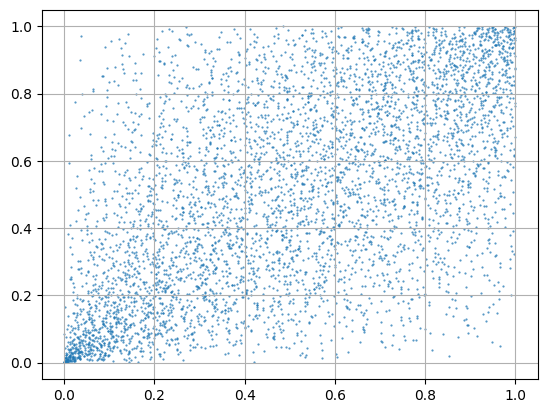

In [1]:
import sys
import matplotlib.pyplot as plt
import torch

# * add proj root folder into path
sys.path.append("..")
import torchvinecopulib as tvc

print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_SIM, num_dim, seed = 5000, 6, 42
# simulate multivariate copula data from bicop
V_mvcp = tvc.vinecop.vcp_from_sim(num_dim=num_dim, seed=seed).sim(
    num_sim=NUM_SIM, device=DEVICE, seed=seed, is_sobol=True
)
# visualize two dim
plt.scatter(*V_mvcp[:, [1, -1]].T.cpu(), s=0.3, alpha=0.8)
plt.grid()
print(tvc.vinecop.DataVineCop.sim.__doc__)

prep for quantile-regression

> suppose we leave `0` at the deepest lv; specify values for all other vertices and explore its cond quantile from 0 to 1.

prep for conditional-simulation

> suppose we leave `[0,1,2,3]` at the deepest lv; specify values for all other vertices.


In [2]:
# quant-reg
tpl_first_qr = tuple([_ for _ in range(1, num_dim)])
dct_first_vs_qr = {
    (_, frozenset()): torch.ones([NUM_SIM, 1], device=DEVICE) * _ / 10
    for _ in tpl_first_qr
}
dct_first_vs_qr[(0, frozenset(range(1, num_dim)))] = torch.linspace(
    1e-5, 1 - 1e-5, NUM_SIM, device=DEVICE
).reshape(-1, 1)
# cond-sim
tpl_first_cs = tuple([_ for _ in range(4, num_dim)])
dct_first_vs_cs = {
    (_, frozenset()): torch.ones([NUM_SIM, 1], device=DEVICE) * _ / 10
    for _ in tpl_first_cs
}

## cvine


### cvine full sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 9,
 'negloglik': -5557.2947,
 'aic': -11096.5893,
 'bic': -11037.9346,
 'matrix': '[[ 4  1  3  0  5  2]'
           ' [-1  1  3  0  5  2]'
           ' [-1 -1  3  0  5  2]'
           ' [-1 -1 -1  0  5  2]'
           ' [-1 -1 -1 -1  5  2]'
           ' [-1 -1 -1 -1 -1  2]]',
 'tpl_sim': (4, 1, 3, 0, 5, 2)}
num hfun call: 0


tensor([[0.5321, 0.9510, 0.4751, 0.2943, 0.2763, 0.5925],
        [0.8576, 0.1386, 0.6297, 0.8050, 0.7968, 0.4584],
        [0.0892, 0.6796, 0.8373, 0.6425, 0.3450, 0.8808],
        ...,
        [0.5925, 0.0395, 0.9081, 0.4518, 0.0742, 0.1256],
        [0.2742, 0.5783, 0.6215, 0.7479, 0.3005, 0.7031],
        [0.8981, 0.5207, 0.2795, 0.2377, 0.9513, 0.3397]], device='cuda:0',
       dtype=torch.float64)

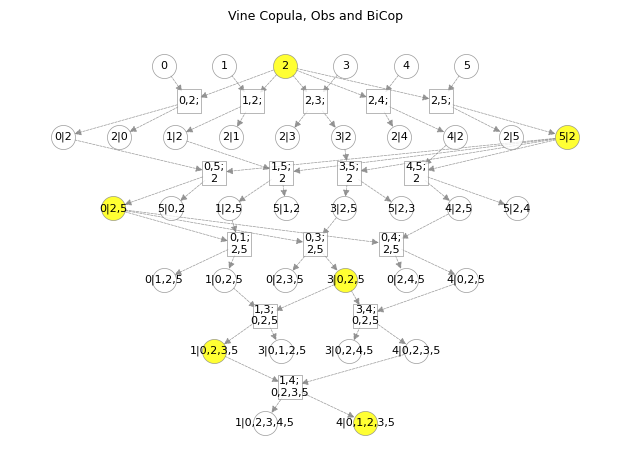

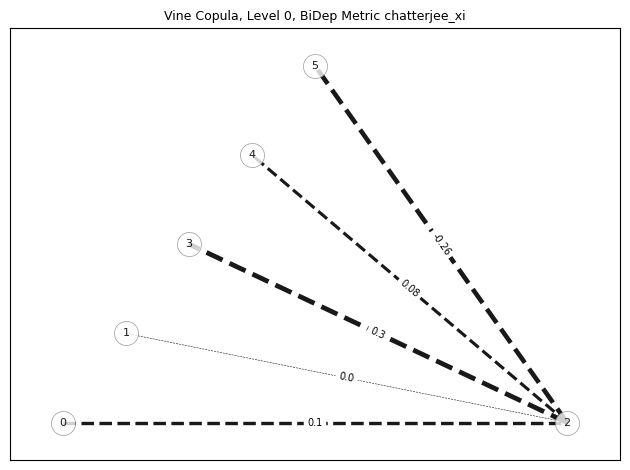

In [3]:
# full sim
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, mtd_vine="cvine")
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag()
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, is_sobol=True)

### cvine quant reg


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 10,
 'negloglik': -5587.8952,
 'aic': -11155.7903,
 'bic': -11090.6184,
 'matrix': '[[ 0  1  3  4  5  2]'
           ' [-1  1  3  4  5  2]'
           ' [-1 -1  3  4  5  2]'
           ' [-1 -1 -1  4  5  2]'
           ' [-1 -1 -1 -1  5  2]'
           ' [-1 -1 -1 -1 -1  2]]',
 'tpl_sim': (0, 1, 3, 4, 5, 2)}
num hfun call: 0


tensor([[0.0147, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.0339, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.0408, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        ...,
        [0.9989, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.9994, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [1.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000]], device='cuda:0')

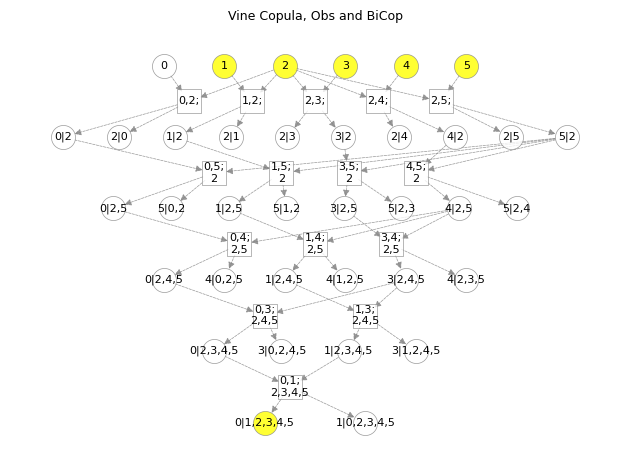

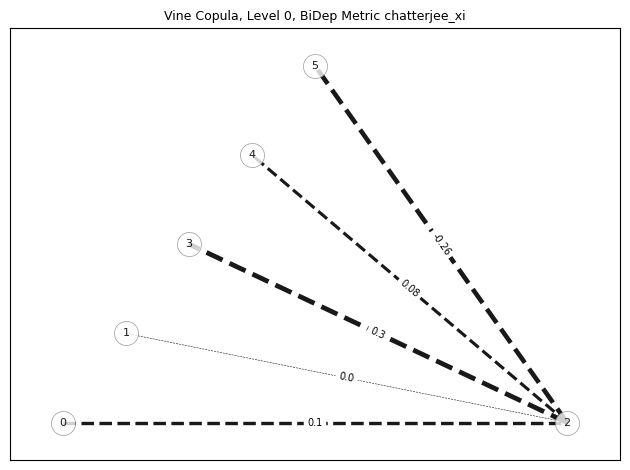

In [4]:
tvc_mdl = tvc.vinecop.vcp_from_obs(
    obs_mvcp=V_mvcp, mtd_vine="cvine", tpl_first=tpl_first_qr
)
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag(tpl_first_vs=dct_first_vs_qr.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs_qr, is_sobol=True)

### cvine cond sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 11,
 'negloglik': -5512.4007,
 'aic': -11002.8013,
 'bic': -10931.1122,
 'matrix': '[[ 1  0  2  3  4  5]'
           ' [-1  0  2  3  4  5]'
           ' [-1 -1  2  3  4  5]'
           ' [-1 -1 -1  3  4  5]'
           ' [-1 -1 -1 -1  4  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'tpl_sim': (1, 0, 2, 3, 4, 5)}
num hfun call: 0


tensor([[0.4950, 0.3756, 0.5216, 0.4667, 0.4000, 0.5000],
        [0.5694, 0.7787, 0.6955, 0.7845, 0.4000, 0.5000],
        [0.3649, 0.1739, 0.8655, 0.5584, 0.4000, 0.5000],
        ...,
        [0.6452, 0.2203, 0.3016, 0.6900, 0.4000, 0.5000],
        [0.3300, 0.8080, 0.8997, 0.8954, 0.4000, 0.5000],
        [0.5491, 0.4417, 0.2628, 0.3627, 0.4000, 0.5000]], device='cuda:0',
       dtype=torch.float64)

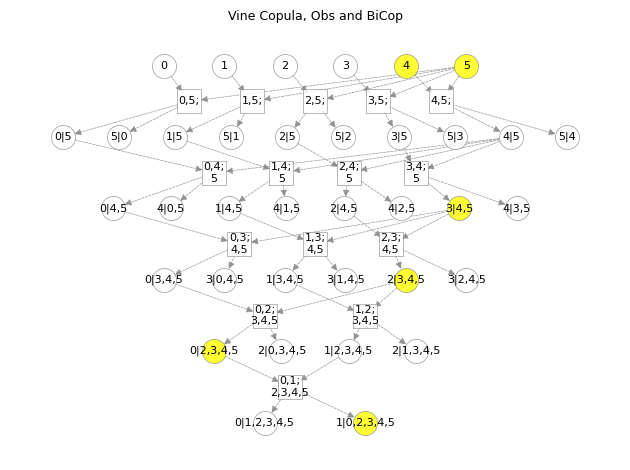

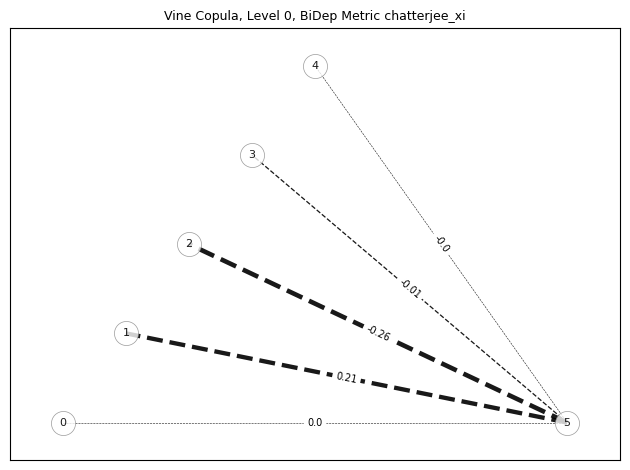

In [5]:
# cond sim
tvc_mdl = tvc.vinecop.vcp_from_obs(
    obs_mvcp=V_mvcp, mtd_vine="cvine", tpl_first=tpl_first_cs
)
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag(tpl_first_vs=dct_first_vs_cs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs_cs, is_sobol=True)

## dvine


### dvine full sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 8,
 'negloglik': -5568.4818,
 'aic': -11120.9636,
 'bic': -11068.826,
 'matrix': '[[ 1  4  0  3  2  5]'
           ' [-1  4  5  2  3  0]'
           ' [-1 -1  0  5  2  3]'
           ' [-1 -1 -1  3  5  2]'
           ' [-1 -1 -1 -1  2  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'tpl_sim': (1, 4, 0, 3, 2, 5)}
num hfun call: 6


tensor([[0.3465, 0.2239, 0.5925, 0.5175, 0.8797, 0.4751],
        [0.9094, 0.6192, 0.4584, 0.6960, 0.4438, 0.6297],
        [0.1280, 0.9475, 0.8808, 0.6127, 0.0889, 0.8373],
        ...,
        [0.1060, 0.2751, 0.1256, 0.4466, 0.0532, 0.9081],
        [0.7842, 0.4834, 0.7031, 0.4498, 0.5411, 0.6215],
        [0.4454, 0.7439, 0.3397, 0.6554, 0.6818, 0.2795]], device='cuda:0',
       dtype=torch.float64)

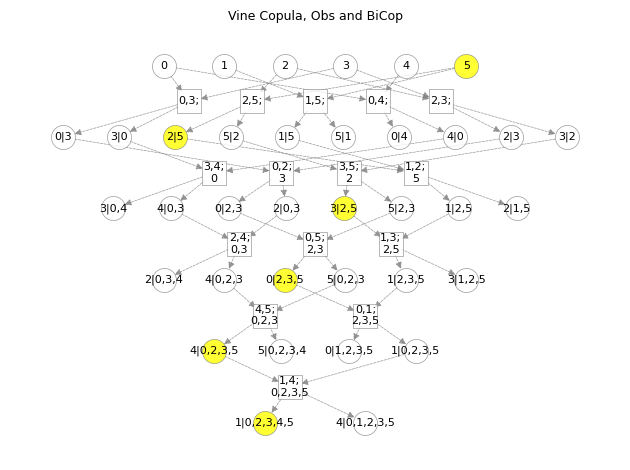

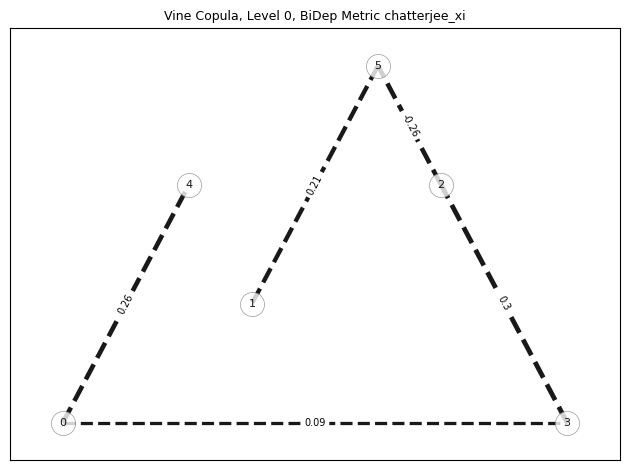

In [6]:
# full sim
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, mtd_vine="dvine")
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag()
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, is_sobol=True)

### dvine quant reg


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 11,
 'negloglik': -5659.8292,
 'aic': -11297.6584,
 'bic': -11225.9692,
 'matrix': '[[ 0  3  2  5  1  4]'
           ' [-1  3  4  1  5  2]'
           ' [-1 -1  2  4  1  5]'
           ' [-1 -1 -1  4  5  1]'
           ' [-1 -1 -1 -1  1  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'tpl_sim': (0, 3, 2, 4, 1, 5)}
num hfun call: 6


tensor([[0.0088, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.0254, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.0321, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        ...,
        [0.9992, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.9996, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [1.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000]], device='cuda:0')

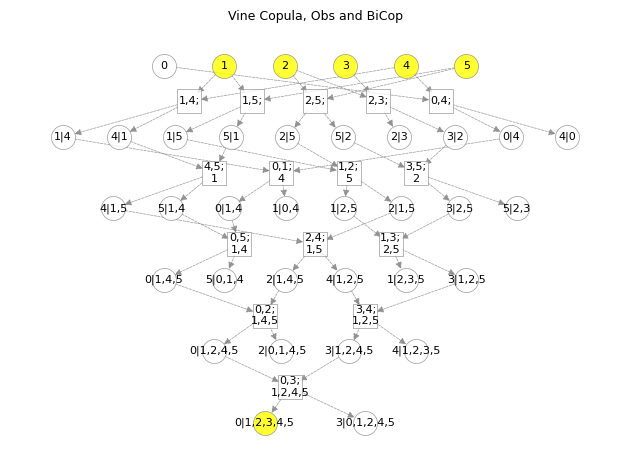

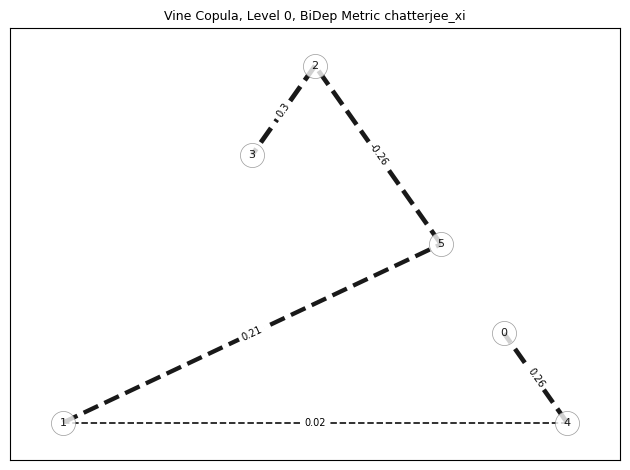

In [7]:
tvc_mdl = tvc.vinecop.vcp_from_obs(
    obs_mvcp=V_mvcp, mtd_vine="dvine", tpl_first=tpl_first_qr
)
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag(tpl_first_vs=dct_first_vs_qr.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs_qr, is_sobol=True)

### dvine cond sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 10,
 'negloglik': -5620.6934,
 'aic': -11221.3868,
 'bic': -11156.2149,
 'matrix': '[[ 1  3  2  0  4  5]'
           ' [-1  3  5  4  0  2]'
           ' [-1 -1  2  5  4  0]'
           ' [-1 -1 -1  0  5  4]'
           ' [-1 -1 -1 -1  4  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'tpl_sim': (1, 3, 2, 0, 4, 5)}
num hfun call: 6


tensor([[0.4638, 0.3830, 0.6077, 0.5129, 0.4000, 0.5000],
        [0.7603, 0.7956, 0.4535, 0.4651, 0.4000, 0.5000],
        [0.5376, 0.1645, 0.9615, 0.8937, 0.4000, 0.5000],
        ...,
        [0.6590, 0.2325, 0.1622, 0.4287, 0.4000, 0.5000],
        [0.8917, 0.8210, 0.6870, 0.3740, 0.4000, 0.5000],
        [0.3871, 0.4619, 0.3378, 0.4149, 0.4000, 0.5000]], device='cuda:0',
       dtype=torch.float64)

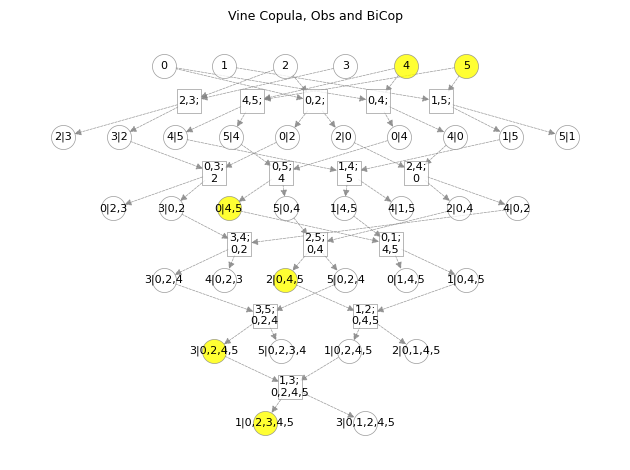

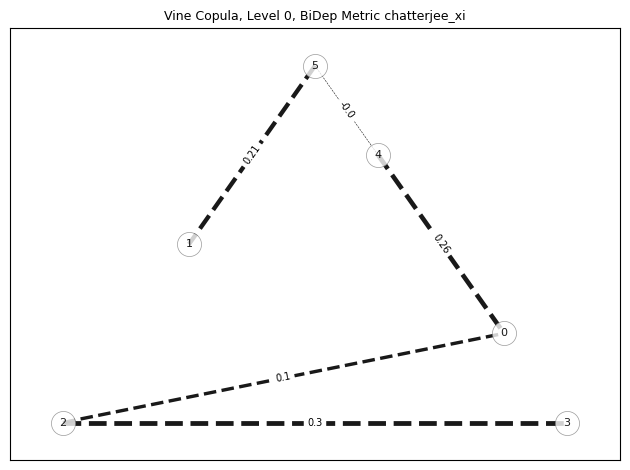

In [8]:
# cond sim
tvc_mdl = tvc.vinecop.vcp_from_obs(
    obs_mvcp=V_mvcp, mtd_vine="dvine", tpl_first=tpl_first_cs
)
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag(tpl_first_vs=dct_first_vs_cs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs_cs, is_sobol=True)

## rvine


### rvine full sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 9,
 'negloglik': -5621.916,
 'aic': -11225.8319,
 'bic': -11167.1772,
 'matrix': '[[ 1  4  0  3  2  5]'
           ' [-1  4  5  3  2  0]'
           ' [-1 -1  0  5  3  2]'
           ' [-1 -1 -1  3  5  2]'
           ' [-1 -1 -1 -1  2  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'tpl_sim': (1, 4, 0, 3, 2, 5)}
num hfun call: 5


tensor([[0.3332, 0.2247, 0.5925, 0.5175, 0.8887, 0.4751],
        [0.9034, 0.6185, 0.4584, 0.6960, 0.4733, 0.6297],
        [0.1414, 0.9474, 0.8808, 0.6127, 0.1037, 0.8373],
        ...,
        [0.1017, 0.2744, 0.1256, 0.4466, 0.0555, 0.9081],
        [0.7961, 0.4834, 0.7031, 0.4498, 0.5670, 0.6215],
        [0.4449, 0.7437, 0.3397, 0.6554, 0.7117, 0.2795]], device='cuda:0',
       dtype=torch.float64)

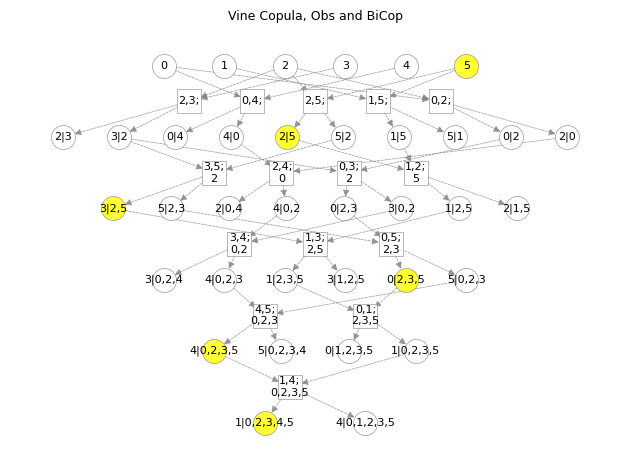

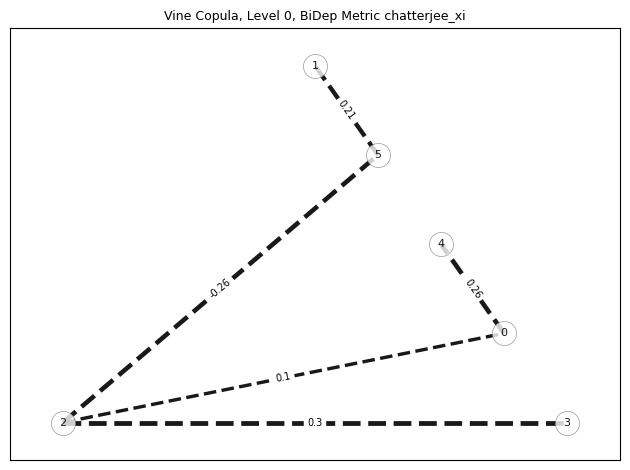

In [9]:
# full sim
tvc_mdl = tvc.vinecop.vcp_from_obs(obs_mvcp=V_mvcp, mtd_vine="rvine")
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag()
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, is_sobol=True)

### rvine quant reg


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 9,
 'negloglik': -5671.6402,
 'aic': -11325.2804,
 'bic': -11266.6256,
 'matrix': '[[ 0  1  5  3  2  4]'
           ' [-1  1  4  3  2  5]'
           ' [-1 -1  4  5  3  2]'
           ' [-1 -1 -1  3  5  2]'
           ' [-1 -1 -1 -1  2  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'tpl_sim': (0, 1, 4, 3, 2, 5)}
num hfun call: 5


tensor([[0.0071, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.0215, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.0275, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        ...,
        [0.9991, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [0.9995, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000],
        [1.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000]], device='cuda:0')

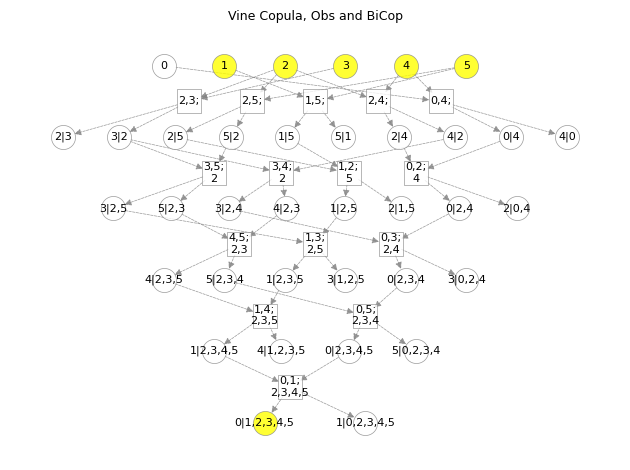

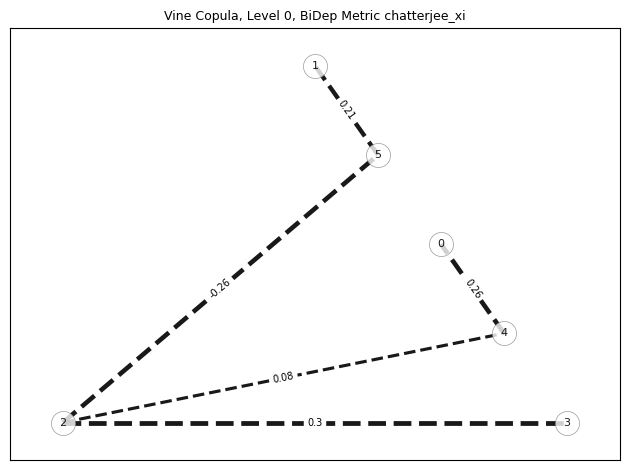

In [10]:
# quant-reg
tvc_mdl = tvc.vinecop.vcp_from_obs(
    obs_mvcp=V_mvcp, mtd_vine="rvine", tpl_first=tpl_first_qr
)
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag(tpl_first_vs=dct_first_vs_qr.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs_qr, is_sobol=True)

### rvine cond sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 6,
 'num_obs': 5_000,
 'num_par': 9,
 'negloglik': -5662.5556,
 'aic': -11307.1112,
 'bic': -11248.4564,
 'matrix': '[[ 1  3  2  0  4  5]'
           ' [-1  3  0  4  5  2]'
           ' [-1 -1  0  2  5  4]'
           ' [-1 -1 -1  2  4  5]'
           ' [-1 -1 -1 -1  4  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'tpl_sim': (1, 3, 0, 2, 4, 5)}
num hfun call: 4


tensor([[0.5544, 0.3804, 0.4963, 0.4087, 0.4000, 0.5000],
        [0.4340, 0.8029, 0.7880, 0.8177, 0.4000, 0.5000],
        [0.9671, 0.1618, 0.5812, 0.1223, 0.4000, 0.5000],
        ...,
        [0.2156, 0.2472, 0.7013, 0.8350, 0.4000, 0.5000],
        [0.6574, 0.8233, 0.8924, 0.8024, 0.4000, 0.5000],
        [0.3421, 0.4652, 0.3977, 0.4751, 0.4000, 0.5000]], device='cuda:0',
       dtype=torch.float64)

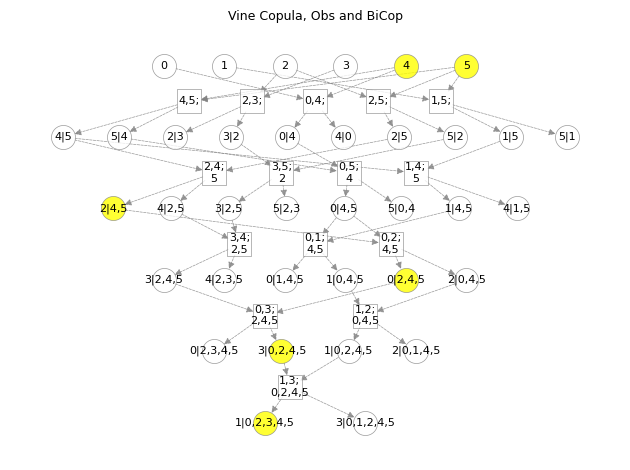

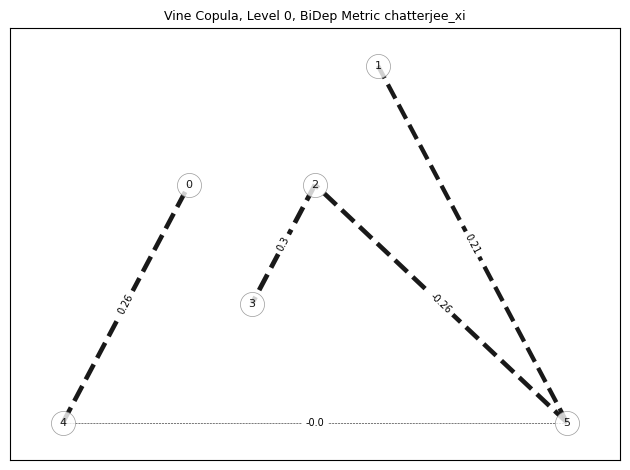

In [11]:
# cond sim
tvc_mdl = tvc.vinecop.vcp_from_obs(
    obs_mvcp=V_mvcp, mtd_vine="rvine", tpl_first=tpl_first_cs
)
print(tvc_mdl)
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tvc_mdl.tpl_sim)[-1]}"
)
tvc_mdl.draw_dag(tpl_first_vs=dct_first_vs_cs.keys())
tvc_mdl.draw_lv()
tvc_mdl.sim(num_sim=NUM_SIM, device=DEVICE, dct_first_vs=dct_first_vs_cs, is_sobol=True)

## tpl_sim for experienced users

> `D` Simulation paths starting from `D` pseudo obs vertices at `D` lvs up to corresponding `D` top lv vertices wont intersect at bicop vertices.
>
> More sampling orders exist. Experienced users may prefer certain ones and it's allowed.


tpl_sim: (3, 2, 1, 5, 4, 0)
num hfun call: 7


tensor([[0.4751, 0.3843, 0.9080, 0.7106, 0.6101, 0.4945],
        [0.6297, 0.9613, 0.1087, 0.3028, 0.5947, 0.8649],
        [0.8373, 0.0992, 0.2193, 0.6666, 0.9343, 0.1320],
        ...,
        [0.9081, 0.1847, 0.0540, 0.0257, 0.3910, 0.7475],
        [0.6215, 0.6306, 0.3475, 0.2545, 0.7712, 0.2656],
        [0.2795, 0.6854, 0.6777, 0.8267, 0.2727, 0.8750]], device='cuda:0',
       dtype=torch.float64)

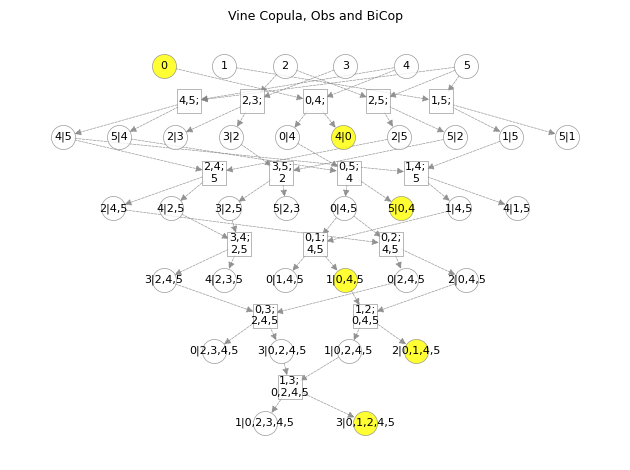

In [12]:
# 2**(D-1)
# ! start from bottom to top, locate a bicop with both vertices not in tpl_sim, pick one vertex to add into tpl_sim
tpl_sim = []
for lv in range(num_dim - 2, -1, -1):
    for edge in tvc_mdl.dct_tree[lv]:
        if len(set(edge[:-1]) - set(tpl_sim)) > 1:
            tpl_sim.append(edge[1])
tpl_sim.extend(set(range(num_dim)) - set(tpl_sim))
tpl_sim = tuple(tpl_sim)
print(f"tpl_sim: {tpl_sim}")
print(
    f"num hfun call: {tvc.util.ref_count_hfunc(dct_tree=tvc_mdl.dct_tree, tpl_sim=tpl_sim)[-1]}"
)
tvc_mdl.draw_dag(tpl_sim=tpl_sim)
tvc_mdl.sim(num_sim=NUM_SIM, tpl_sim=tpl_sim, device=DEVICE, is_sobol=True)